In [1]:
from datasets import load_dataset

ds = load_dataset("artem9k/ai-text-detection-pile")
ds

DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'text'],
        num_rows: 1392522
    })
})

Convert huggingface format to Pandas format

In [2]:
df = ds['train'].to_pandas()

In [3]:
df.shape

(1392522, 3)

In [4]:
df

,source,id,text
0,human,0,12 Years a Slave: An Analysis of the Film Essa...
1,human,1,20+ Social Media Post Ideas to Radically Simpl...
2,human,2,2022 Russian Invasion of Ukraine in Global Med...
3,human,3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,human,4,A Charles Schwab Corporation Case Essay\n\nCha...
...,...,...,...
1392517,ai,1418649,"Today, I accomplished a major feat. I stepped ..."
1392518,ai,1418650,As rockets rain down from the sky\nEurope trem...
1392519,ai,1418651,"On January 6th, 2023, the world lost a true pi..."
1392520,ai,1418652,A gene bank is a repository of genetic materia...


In [23]:
# replace 'human' with 0, 'ai' with 1
df['source'] = df['source'].replace({'human': 0, 'ai': 1})
df

,source,id,text
0,0,0,12 Years a Slave: An Analysis of the Film Essa...
1,0,1,20+ Social Media Post Ideas to Radically Simpl...
2,0,2,2022 Russian Invasion of Ukraine in Global Med...
3,0,3,533 U.S. 27 (2001) Kyllo v. United States: The...
4,0,4,A Charles Schwab Corporation Case Essay\n\nCha...
...,...,...,...
1392517,1,1418649,"Today, I accomplished a major feat. I stepped ..."
1392518,1,1418650,As rockets rain down from the sky\nEurope trem...
1392519,1,1418651,"On January 6th, 2023, the world lost a true pi..."
1392520,1,1418652,A gene bank is a repository of genetic materia...


## Prepocessing

In [24]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42
)

In [25]:
import torch
from transformers import (
    RobertaTokenizerFast,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig
)

from huggingface_hub import HfFolder, notebook_login

In [26]:
notebook_login()

In [27]:
[len(train_df), len(test_df)]

[1114017, 278505]

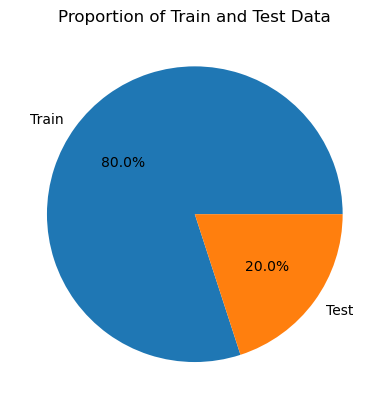

In [18]:
import matplotlib.pyplot as plt
plt.pie([len(train_df), len(test_df)], autopct='%1.1f%%', labels=['Train', 'Test'])
plt.title('Proportion of Train and Test Data')
plt.show()

In [28]:
train_df.head()

,source,id,text
1209079,1,1229041,"When the dust settles, will there be a strong ..."
231479,0,231479,Still loading...\n\nA B C D E F G H I J K L M ...
955953,0,975123,Punch. Kick. Dodge. Punch. Kick. Dodge. A ryth...
1265850,1,1285812,The U.S. State Department has launched an ongo...
303442,0,303442,SACRAMENTO (CBS13) – Sacramento Mayor Kevin Jo...


In [ ]:
model_id = 'roberta-base'

tokenizer = RobertaTokenizerFast.from_pretrained(model_id)


def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=512)

train_df = train_df.map(tokenize, batched=True, batch_size=len(train_df))
test_df = test_df.map(tokenize, batched=True, batch_size=len(test_df))



### Set dataset format to tensors

In [ ]:
# convert pandas to huggingface dataset
from datasets import Dataset

train_df = Dataset.from_pandas(train_df)
test_df = Dataset.from_pandas(test_df)

# convert huggingface to tensor dataset format
train_df.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_df.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

## Fine-tuning RoBERTa for text classification

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(model_id, config)